# Build an optimal neural-network classifier: step by step

We are going to implement an optimal neural network classifier to separate two Gaussian distributions.

Assume that $x$ follows one of the conditional probablity densities $p_0(x) = p(x|y=0)$ and $p_1(x) = p(x|y=1)$ on $\mathbb{R}^N$. To classify $x$, we minimize the logistic loss. More precisely, for a neural-network prediction $\hat{y}(x,\theta)$, we want to find an optimal $\theta$ such that the following loss $J$ is minimal,
$$ J (\theta) = - \mathbb{E}_{x \sim p_1 } [ \log( \hat{y}(x,\theta) )  ]-  \mathbb{E}_{x \sim p_0} [\log( 1- \hat{y}(x,\theta) ) ]. $$

In theory, it is known that the optimal $\hat{y}^\ast$ has the following form
$$
    \hat{y}^\ast(x) = \frac{1}{1 + e^{-f^\ast (x)} } , \quad f^\ast(x) = \log p_1(x) -\log p_0(x) .
$$
Note that if $p_1(x)$ is much larger than $p_0(x)$, then the prediction $\hat{y}^\ast(x)$ is close to $1$. This prediction is consistent with the optimal Bayes classifier (which predicts $1$ when $p_1(x) > p_0(x)$). Assume $p_0 = \mathcal{N}(\mu_0 , \sigma_0^2 I)$ and
$p_1 = \mathcal{N}(\mu_1 , \sigma_1^2 I)$, then $f^\ast(x)$ can be computed explicitly (TODO).

We are intersted in training a neural networks to approximate $f^\ast$. Based on the universal approximation theorem (https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf), we first choose the following architecture (Definition 2.2)
$$
    f (x,\theta)  = \sum_{j=1}^q \beta_j \sigma ( w_{j}^\intercal x + b_j) + \beta_0, \quad
     \beta_j \in \mathbb{R}, w_{j} \in \mathbb{R}^N, b_j \in \mathbb{R} ,
$$
with the sigmoid non-linear activation function $\sigma$. The prediction  $ \hat{y}(x,\theta) = \sigma( f(x,\theta)) =1 / (1 + e^{ - f (x,\theta) } ) $. The differentiability of $\hat{y}(x,\theta)$ with respect to $\theta$ allows one to optimize the logistic loss $J(\theta)$.

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from keras import optimizers
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers

2025-06-19 09:27:16.374851: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 09:27:16.381188: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 09:27:17.108020: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 09:27:20.049591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 09:27:21.985447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

# One-dimensional case

- Consider $N=1$, with $\mu_0= -1$, $\mu_1=1$, $\sigma_0=1$ and $\sigma_1=2$.
- The first dense layer computes $\sigma(Wx + b)$ where $W = [w_1^\intercal;\cdots;w_q^\intercal] \in \mathbb{R}^{q,N}$ and $b = (b_1 ,\cdots , b_q) \in \mathbb{R}^q$. We assume that the input $x$ is in the mini-batch form of size $N \times m$.

In [4]:
N = 1
mu0 = -1
mu1 = 1
sigma0 = 1
sigma1 = 2
q = 10
m = 2

## Use Keras to build the initial model

In [5]:
# Build the model
model = Sequential([
    # First hidden layer with q neurons and sigmoid activation
    Dense(q, activation='relu', input_shape=(N,)),
    # Output layer with a single neuron
    Dense(1, activation='sigmoid')
])

/home/besbesines/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-19 09:27:23.790579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-19 09:27:24.099062: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the r

### Evaluation
- Before training, compare the initial model with the optimal prediction $\hat{y}^\ast$

/tmp/ipykernel_6262/2011100098.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_arr,y_arr_model,'b',label=model_label, color=color)


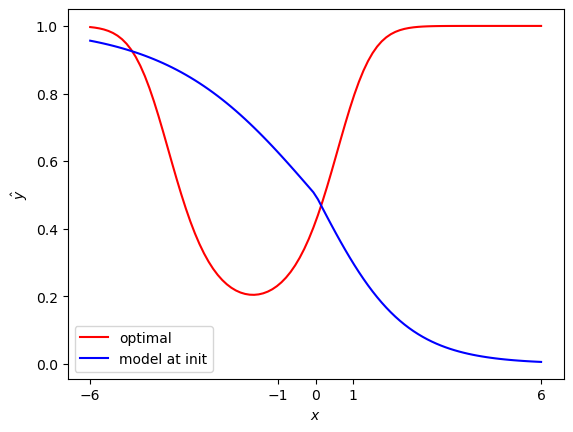

In [6]:
def f_star(x):
    # Compute f*(x) = log p_1(x) - log p_0(x)
    term1 = -0.5 * np.log(2 * np.pi * sigma1**2) - 0.5 * ((x - mu1)**2) / sigma1**2
    term2 = -0.5 * np.log(2 * np.pi * sigma0**2) - 0.5 * ((x - mu0)**2) / sigma0**2
    return term1 - term2

# compute along x in [-10,10]
# the function model(x) and \hat{y}^\ast
def opty_1d(x):
    # Compute \hat{y}^\ast(x) = 1/(1+e^(-f*(x)))
    return 1 / (1 + np.exp(-f_star(x)))

def plot_y(model,model_label, color='b'):
    m = 100
    x_arr = np.linspace(-6,6,m)
    y_arr_opt = opty_1d(x_arr)
    y_arr_model = model(x_arr.reshape((m,N)))[:,0]
    plt.plot(x_arr,y_arr_opt,'r',label='optimal')
    plt.plot(x_arr,y_arr_model,'b',label=model_label, color=color)
    plt.xticks([-6,-1,0,1,6])
    plt.legend()
    plt.ylabel('$\hat{y}$')
    plt.xlabel('$x$')

plot_y(model,'model at init')

### Implement generate_samples_1d

We are going to sample $m$ data points of $(x_i,y_i)$ from the distributions $p_0$ and $ p_1$.

The following function generate_samples_1d(m) returns $m$ i.i.d sample points in the 1d case.

In [7]:
def generate_samples_1d(m):
    # Parameters for the Gaussian distributions
    mu_0 = -1
    mu_1 = 1
    sigma_0 = 1
    sigma_1 = 2

    # Initialize arrays to store samples and labels
    X = np.zeros((1, m))
    Y = np.zeros((1, m))

    for i in range(m):
        # Randomly decide which distribution to sample from
        if np.random.rand() < 0.5:
            # Sample from p_0
            X[:, i] = np.random.normal(mu_0, sigma_0)
            Y[0, i] = 0
        else:
            # Sample from p_1
            X[:, i] = np.random.normal(mu_1, sigma_1)
            Y[0, i] = 1

    return X, Y


Assume that we have access to $m$ labels $(y_1,\cdots,y_m)$ and $m$ predictions $\hat{y}=(\hat{y}_1,\cdots,\hat{y}_m)$, and we are going to use the logistic loss (also known as the binary cross entropy)
$$
J = - \frac{1}{m} \sum_{i=1}^m ( \log(\hat{y}_i ) y_i +  \log(1-\hat{y}_i ) (1-y_i ) ).
$$

### Training
- Tune the number of (artificial) neurons $q \in \{10,100,1000\}$.

Training model with q = 10


100%|██████████| 100/100 [00:04<00:00, 21.51it/s]
/tmp/ipykernel_6262/2011100098.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_arr,y_arr_model,'b',label=model_label, color=color)


Training model with q = 100


100%|██████████| 100/100 [00:04<00:00, 21.90it/s]


Training model with q = 1000


100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


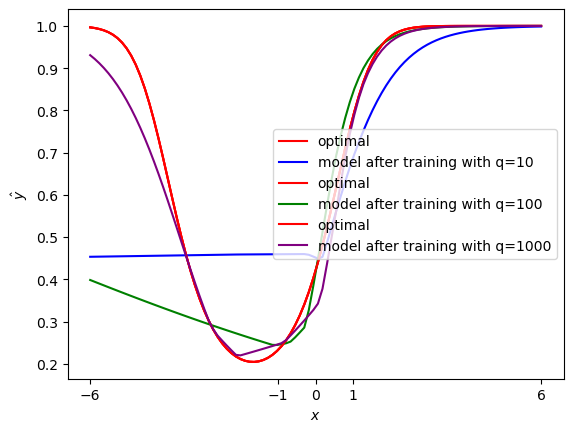

In [8]:
from tqdm import tqdm 

# Define different values of q to tune
q_values = [10, 100, 1000]
epochs = 100
colors = ['blue', 'green', 'purple']  # Different colors for each q


# Train and evaluate models for different values of q
for q, color in zip(q_values, colors):
    X, y = generate_samples_1d(q)
    print(f"Training model with q = {q}")

    # Build the model
    model = Sequential([
        Dense(q, activation='relu', input_shape=(N,)),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with binary cross-entropy loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    for epoch in tqdm(range(epochs)):
        model.fit(X.T,y.T, verbose=0)

    plot_y(model,'model after training with q='+str(q), color)
    


## Use Keras to build the $\Sigma$$\Pi$ model

Based on the universal approximation theorem (https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf), we now choose the following architecture (Definition 2.4)
$$
    f (x,\theta)  = \sum_{j=1}^q \beta_j \prod_{i=1}^k \sigma ( w_{j i}^\intercal x + b_{j i}) + \beta_0, \quad
     \beta_j \in \mathbb{R}, w_{ji} \in \mathbb{R}^N, b_{ji} \in \mathbb{R} ,
$$
with the sigmoid non-linear activation function $\sigma$. The prediction  $ \hat{y}(x,\theta) = \sigma( f(x,\theta)) =1 / (1 + e^{ - f (x,\theta) } ) $.

### Implementation of a product layer

In [10]:
class ElementwiseProd(layers.Layer):
    def __init__(self, q, k, act, **kwargs):
        super().__init__(**kwargs)
        self.q = q
        self.k = k
        self.act = layers.Activation(act)

    def build(self, input_shape):
        # Initialize weights for the layer
        self.w = self.add_weight(shape=(self.q, self.k, input_shape[-1]), initializer='glorot_uniform', name='w')
        self.b = self.add_weight(shape=(self.q, self.k), initializer='zeros', name='b')
        self.beta = self.add_weight(shape=(self.q,), initializer='glorot_uniform', name='beta')
        self.beta0 = self.add_weight(shape=(1,), initializer='zeros', name='beta0')
        super().build(input_shape)

    def call(self, inputs):
        # Compute the product terms
        prod_terms = []
        for j in range(self.q):
            prod_term = tf.ones_like(inputs[..., :1])
            for i in range(self.k):
                # Ensure inputs and weights are properly shaped for matrix multiplication
                linear = tf.add(tf.tensordot(inputs, self.w[j, i], axes=[[-1], [-1]]), self.b[j, i])
                prod_term = tf.multiply(prod_term, self.act(linear))
            prod_terms.append(prod_term)

        # Sum the product terms with beta weights
        sum_terms = tf.zeros_like(inputs[..., :1])
        for j in range(self.q):
            sum_terms = tf.add(sum_terms, tf.multiply(self.beta[j], prod_terms[j]))

        # Add beta0
        output = tf.add(sum_terms, self.beta0)
        return output

### Test

In [38]:
# Parameters
N = 1
q = 10
k = 3
activation = 'sigmoid'

# Define the model
inputs = tf.keras.Input(shape=(N,))
prod_layer = ElementwiseProd(q=q, k=k, act=activation)
product = prod_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=product)

# Test input
x_test = np.random.randn(1, N)
y_model = model(x_test).numpy()

# Manual computation
W = []
b = []

for layer in range(k):
    w_i, b_i = [np.random.randn(N, q), np.random.randn(1, q)]
    W.append(w_i)
    b.append(b_i)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

outputs = []
for i in range(k):
    y = np.matmul(x_test, W[i]) + b[i]
    y = sigmoid(y)
    outputs.append(y)

y_true = outputs[0]
for i in range(1, k):
    y_true *= outputs[i]

print("Résultat modèle Keras")
print(y_model)
print("Résultat calculé")
print(y_true)
print("Erreur relative max")
print(np.max(np.abs(y_model - y_true) / np.abs(y_true)))

Résultat modèle Keras
[[0.0124007]]
Résultat calculé
[[0.01251653 0.25750755 0.41936353 0.0791291  0.18750261 0.12133006
  0.32508729 0.1085954  0.22303434 0.14265609]]
Erreur relative max
0.9704297088749705


### Model definition



### Training

In [ ]:
### TODO ###

### TODO ###

# Compare the function model(x) and \hat{y}^\ast
plot_y(model,'model after training')